142773
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 16)          2284368   
                                                                 
 dropout (Dropout)           (None, 1000, 16)          0         
                                                                 
 conv1d (Conv1D)             (None, 998, 32)           1568      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                 

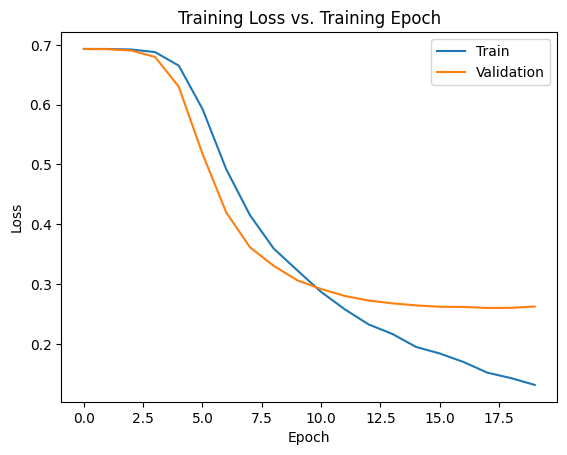

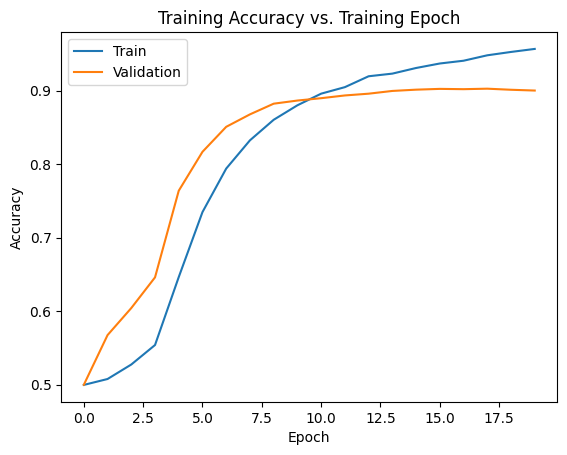

In [1]:
# import required packages
from glob import glob
import os,re,string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, GlobalAveragePooling1D, Dense
from keras.optimizers import Adam

# Loading data from folder
def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r',encoding="utf8").read())
            labels.append(idx)
    
    return texts, np.array(labels).astype(np.int64)

# Preprocessing
def preprocess_reviews(reviews):
    tokens = re.compile("[.;:!#\'?,\"()\[\]]|(<br\s*/><br\s*/>)|(\-)|(\/)")
    
    return [tokens.sub("", line.lower()) for line in reviews]

# IMPLEMENTATION
if __name__ == "__main__":
  
	# 1. load your training data  
  PATH='../data/aclImdb/'
  names = ['neg','pos']
  x_train, y_train = load_texts_labels_from_folders(f'{PATH}train', names)

  x_train_clean = preprocess_reviews(x_train)
  
  # Tokenizer
  tokenizer = keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(x_train_clean) 
  x_train = tokenizer.texts_to_sequences(x_train_clean)

  from sklearn.model_selection import train_test_split
  x_train = keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=1000)  
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

	# 2. Train network
  word_size = len(tokenizer.word_index)+1
  print(word_size)
  max_sequence_length = 1000
  model = Sequential()
  model.add(Embedding(word_size, 16, input_length=max_sequence_length))
  model.add(Dropout(0.5))  # dropout rate for stronger regularization
  model.add(Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu'))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))  # Another dropout layer for further regularization
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))  # Another dropout layer for further regularization
  model.add(Dense(1, activation='sigmoid'))
    
  model.summary() 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=1, batch_size=600)

  print('The final training accuracy is ',history.history['acc'][-1]*100)
  
  plt.plot(history.history['loss'], label='Train')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title('Training Loss vs. Training Epoch')
  plt.legend(loc='upper right')

  plt.figure()
  plt.plot(history.history['acc'], label='Train')
  plt.plot(history.history['val_acc'], label='Validation')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title('Training Accuracy vs. Training Epoch')
  plt.legend(loc='upper left')

  # 3. Save your model
  model.save("../models/NLP_model.h5")
        